# Geologic profiles with pygsf

*Doc started 2019-05-12*

*Current version: 2021-06-05*

*Last running version: 2021-06-05*

This notebook describes the calculation of topographic profiles. As input data we need a DEM and a profile. 

Figures are plotted via matplotlib:

In [1]:
%matplotlib inline

Data sets can be plotted with pprint:

In [2]:
from pprint import pprint

## 1-  Mount Alpi (Lucania, Southern Italy)

### DEM input

The source DEM is from publicly available Aster data and refers to the the Mt. Alpi zone (Lucania, Southern Italy):

In [3]:
source_data = "/home/mauro/Documents/projects/gsf/example_data/mt_alpi/malpi_aster_w4u3.tif"

We read the DEM info using a GDAL-based raster-band reader method:

In [4]:
from pygsf.io.rasters.gdal import try_read_raster_band
success, result = try_read_raster_band(raster_source=source_data)

In [5]:
print(success)

True


The raster was successfully read. The result is composed by a set of various infos:

In [6]:
geotransform, projection, band_params, data = result

In [7]:
for info in (geotransform, projection, band_params, data):
    print(f"info type: {type(info)}:\n\n{info}\n\n")

info type: <class 'pygsf.geometries.grids.geotransform.GeoTransform'>:

[ 5.80814583e+05  2.72759535e+01  0.00000000e+00  4.44429946e+06
  0.00000000e+00 -2.72759531e+01]


info type: <class 'str'>:

PROJCS["WGS 84 / UTM zone 33N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",15],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32633"]]


info type: <class 'dict'>:

{'dataType': 'Float32', 'unitType': '', 'stats': {'min': 0.0, 'max': 1829.0, 'mean': 1092.0445648248, 'std_dev': 302.5523744617}, 'noData': 3.4028234663852886e+38, 'numOver

The EPSG projection code is 32633.

The 'data' variable stores the raster values as a Numpy array.

Using this information, we can compose a *GeoArray* instance. It combines the geotransform, the EPSG code and one or more arrays (in this case, only one array) into a georeferenced object, that can be considered a *grid*:

In [8]:
from pygsf.georeferenced.rasters import *
geoarray = GeoArray(
    geotransform=geotransform,
    epsg_code=32633,
    arrays=[data]
)

We can plot this grid with a utility function:

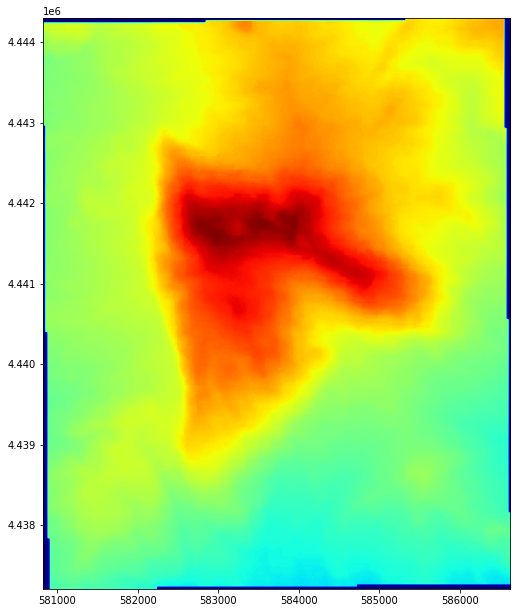

In [9]:
from pygsf.plots.rasters import plot_grid
fig = plot_grid(geoarray)

### Source profile

In order to digitally create a topographic/geological profile, we first need to define a trace with wich to extract elevations from DEMs and afterwards to manipulate geological layers. 

In this example, we read the trace from a line shapefile using a function based on GDAL/OGR.

In [10]:
from pygsf.io.vectors.gdal import try_read_line_shp_with_attr

src_profile_shapefile_pth = "/home/mauro/Documents/GeoDati/italia/macrozone/merid/regioni/basilicata/mt_alpi/livelli/profile_two.shp"
success, result = try_read_line_shp_with_attr(src_profile_shapefile_pth)

In [11]:
print(success)

True


The result is composed by a list of GeoLines-attributes pairs (stored as tuples). Each attribute set is applicable to all of the GeoLine list elements: remember that the source layer could store MultiLines. In the current case, we have just a single record, composed by a list with a single GeoLine2D and an empty attribute tuple (last nested empty tuple in printed results).

In [12]:
print(result)

[([GeoLine2D with 5 points: (15.9606, 40.1331) ... (16.0100, 40.1058) with EPSG code 4326], ())]


In [13]:
[geoline], _ = result[0]

This *GeoLine2D* instance is a georeferenced line dataset, in this case containing a single line.

In [14]:
print(geoline.shape)

Line2D with 5 points: (15.9606, 40.1331) ... (16.0100, 40.1058)


This line is a Line2D instance, made up by 5 points.

The EPSG code can be extracted with the *epsg_code* attribute.

In [15]:
print(geoline.epsg_code)

4326


The spatial reference of the line profile is EPSG: 4326 (WGS1984), *i.e.*, different from the raster DEM CRS. 
Therefore a projection change is required before plotting against the DEM.

In [16]:
projected_geoline = geoline.project(
        dest_epsg_cd=32633
    )

In [17]:
print(projected_geoline)

GeoLine2D with 5 points: (581836.8042, 4442973.6024) ... (586078.8498, 4439991.3755) with EPSG code 32633


The projected georeferenced line is a GeoLine2D, not *None*, so we got a valid result, made up of a georeferenced line (GeoLine2d) whose CRS is EPSG:32633.

Now we plot the profile trace in the previous figure.

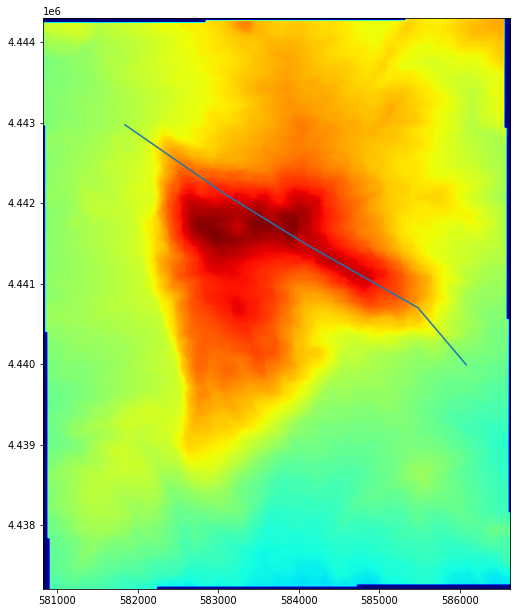

In [18]:
from pygsf.plots.vectors import plot_line

line = projected_geoline.shape
plot_line(fig, line)

### Initializing a line profiler

*gsf* uses the **profiler** concept to act as the protagonist in the profile process. A profiler is the object that stores the trace information and that knows how to interact with DEMs and geological layers in order to create, in a stepwise manner, a geological profile. Technically, a profiler stores a source line, its EPSG code and the sampling distance. It is therefore named **LineProfiler**.
In its essence, it corresponds to a list of segments, each with the same EPSG code and sampling distance.
It is the SegmentProfiler that really knows how to interact with DEMs and geological layers.


Another variation of profiler type, is the **ParallelProfiler**, a set of LineProfilers parallel to each other and uniformly spaced in a direction perpendicular to the line (provided by line first and last points) by a given distance. We will look at it later (provided the notebook will be expanded).

In [19]:
from pygsf.profiles.profilers import LineProfiler

Input parameters for the LineProfiler creation are the line, the densify distance and the EPSG code.

In [20]:
line_profiler = LineProfiler(
    src_line=line,
    epsg_code=32633)

Having created a LineProfiler instance, we can now use it on a DEM, to create a topographic profile.

In [21]:
topographic_profile = line_profiler.profile_grid(
    geoarray=geoarray,
    sampling_distance=10 # meters
)

In its essence, a topographic profile is a collection of x-y coordinates in a 2D space. It is embodied as a XYArrayPair, that is composed by a couple of Numpy arrays, representing the s and z coordinates, plus an optional array of break points, i.e., where the profile changes direction.  

In [22]:
print(type(topographic_profile))

<class 'pygsf.geometries.shapes.space2d.XYArrayPair'>


The array of s (horizontal) values along the x axis is provided by: 

In [23]:
topographic_profile.x_arr()

array([   0.,   10.,   20.,   30.,   40.,   50.,   60.,   70.,   80.,
         90.,  100.,  110.,  120.,  130.,  140.,  150.,  160.,  170.,
        180.,  190.,  200.,  210.,  220.,  230.,  240.,  250.,  260.,
        270.,  280.,  290.,  300.,  310.,  320.,  330.,  340.,  350.,
        360.,  370.,  380.,  390.,  400.,  410.,  420.,  430.,  440.,
        450.,  460.,  470.,  480.,  490.,  500.,  510.,  520.,  530.,
        540.,  550.,  560.,  570.,  580.,  590.,  600.,  610.,  620.,
        630.,  640.,  650.,  660.,  670.,  680.,  690.,  700.,  710.,
        720.,  730.,  740.,  750.,  760.,  770.,  780.,  790.,  800.,
        810.,  820.,  830.,  840.,  850.,  860.,  870.,  880.,  890.,
        900.,  910.,  920.,  930.,  940.,  950.,  960.,  970.,  980.,
        990., 1000., 1010., 1020., 1030., 1040., 1050., 1060., 1070.,
       1080., 1090., 1100., 1110., 1120., 1130., 1140., 1150., 1160.,
       1170., 1180., 1190., 1200., 1210., 1220., 1230., 1240., 1250.,
       1260., 1270.,

The elevations are provided by the *y_arr* method:

In [24]:
topographic_profile.y_arr()

array([1034.47340992, 1037.15767219, 1040.14209067, 1043.378207  ,
       1046.34929495, 1048.37921978, 1050.844921  , 1053.88104637,
       1056.48452759, 1058.71046203, 1059.96206549, 1060.29186574,
       1060.5932151 , 1060.89456447, 1062.00339518, 1064.55689053,
       1066.98453695, 1069.42041114, 1071.91675547, 1074.00872127,
       1075.58633878, 1077.20935426, 1078.83236975, 1080.45538523,
       1081.89420284, 1083.35879765, 1084.94924139, 1086.8924452 ,
       1089.33728552, 1091.74354431, 1094.42825136, 1100.29991209,
       1106.04572391, 1111.66568679, 1117.62322121, 1123.58139646,
       1129.53957171, 1135.62589144, 1142.5497988 , 1150.32024736,
       1158.01386362, 1164.13498284, 1170.50779991, 1177.02175742,
       1183.57174884, 1190.08753907, 1196.60332931, 1203.38919015,
       1209.80125686, 1215.68080775, 1221.46335138, 1227.50320063,
       1233.79474773, 1239.12516393, 1250.99509046, 1264.2544625 ,
       1277.51383455, 1286.91541701, 1292.53065351, 1298.27173

The list of break points along the profile is given by:

In [25]:
topographic_profile.x_breaks()

array([   0.        , 1520.72806236, 2700.70025808, 4296.28180226,
       5225.06643905])

To plot the profile, we use the *plot* function from the *plots.profiles_matplotlib* module:

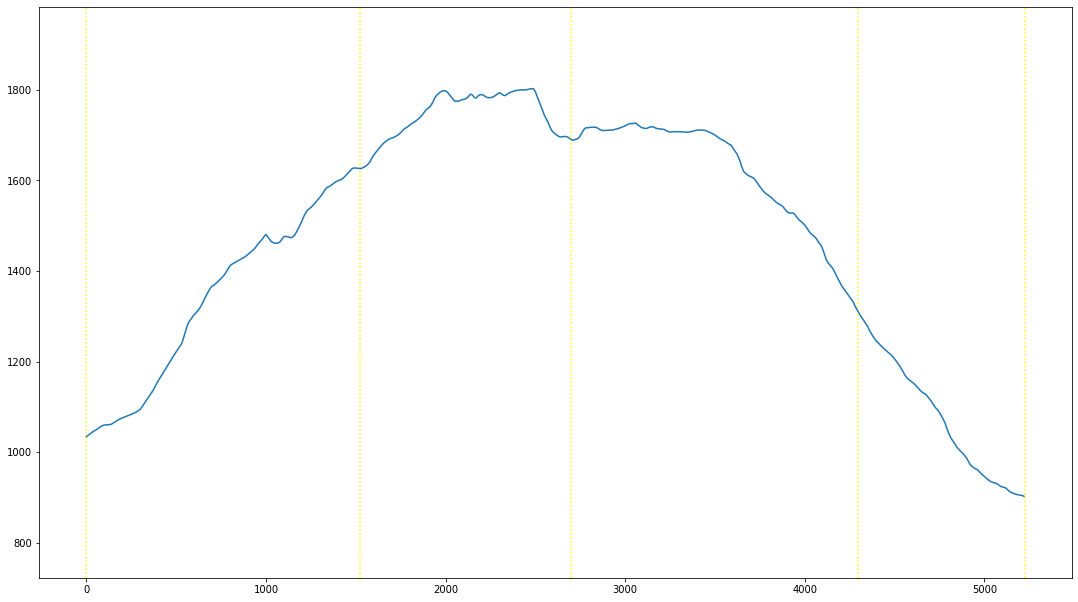

In [26]:
from pygsf.plots.profiles_matplotlib import plot

fig = plot(topographic_profile)

The plot can be customized by passing keyword arguments, some of which are proper Matplotlib parameters:

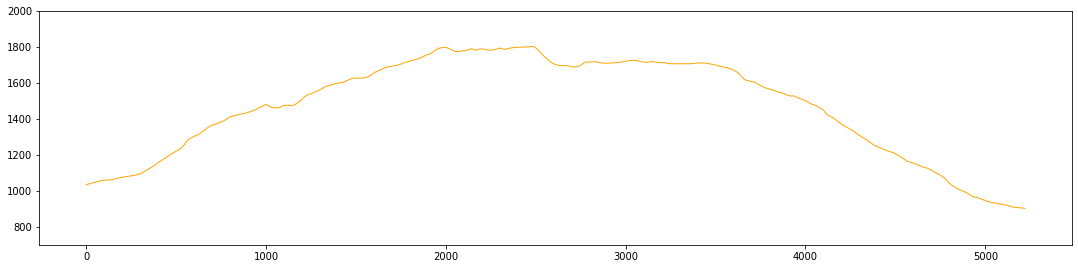

In [27]:
fig = plot(
            topographic_profile, 
            color='orange', # line color
            aspect=1,  # the ratio of y unit to the x unit, i.e., the vertical exaggeration
            linewidth=1, # the line width
            z_min=700,  # the plot minimum elevation
            z_max=2000,  # the plot maximum elevation 
            breaklines=False  # whether to plot the break points as vertical lines
)

In [28]:
topographic_profile.x_breaks()

array([   0.        , 1520.72806236, 2700.70025808, 4296.28180226,
       5225.06643905])

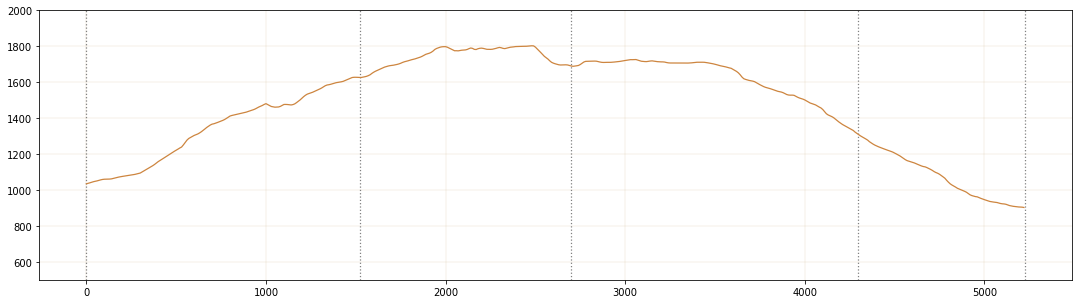

In [29]:
fig = plot(
    topographic_profile, 
    color='peru', 
    aspect=1, 
    linewidth=1.25, 
    z_min=500, 
    z_max=2000, 
    grid=True, 
    breaklines=True,
    breaklines_color='grey',
    breaklines_width=1.25
)

We can also calculate and plot the slopes of the profile.
For instance, the directional (from profile start to end, positive upwards, negative downwards) slopes along the profile are extracted and plotted with:

In [30]:
topographic_profile.dir_slopes_degrees()

array([ 1.50254981e+01,  1.66173050e+01,  1.79321842e+01,  1.65471475e+01,
        1.14746993e+01,  1.38511371e+01,  1.68889477e+01,  1.45928976e+01,
        1.25490746e+01,  7.13406200e+00,  1.88893156e+00,  1.72608231e+00,
        1.72608231e+00,  6.32728505e+00,  1.43243544e+01,  1.36454143e+01,
        1.36899239e+01,  1.40165284e+01,  1.18156837e+01,  8.96519228e+00,
        9.21880798e+00,  9.21880798e+00,  9.21880798e+00,  8.18762623e+00,
        8.33227037e+00,  9.03688233e+00,  1.09966914e+01,  1.37384086e+01,
        1.35296356e+01,  1.50278752e+01,  3.04200104e+01,  2.98808645e+01,
        2.93358251e+01,  3.07845170e+01,  3.07872268e+01,  3.07872268e+01,
        3.13260306e+01,  3.46983699e+01,  3.78488093e+01,  3.75733021e+01,
        3.14712973e+01,  3.25086167e+01,  3.30800501e+01,  3.32247644e+01,
        3.30874220e+01,  3.30874220e+01,  3.41602695e+01,  3.26682635e+01,
        3.04536160e+01,  3.00388354e+01,  3.11313433e+01,  3.21762438e+01,
        2.80594728e+01,  

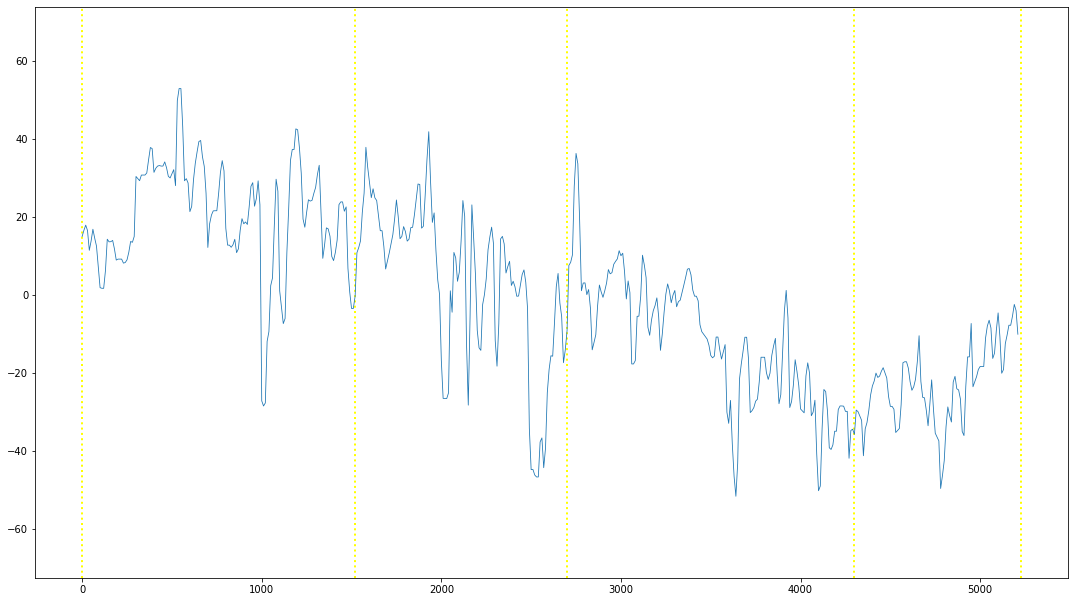

In [31]:
fig = plot(
    topographic_profile.as_dir_slopes_degrees(),
    linewidth=0.8,
    breaklines_color='yellow',
    breaklines_width=2
)

To plot the absolute slopes we use:

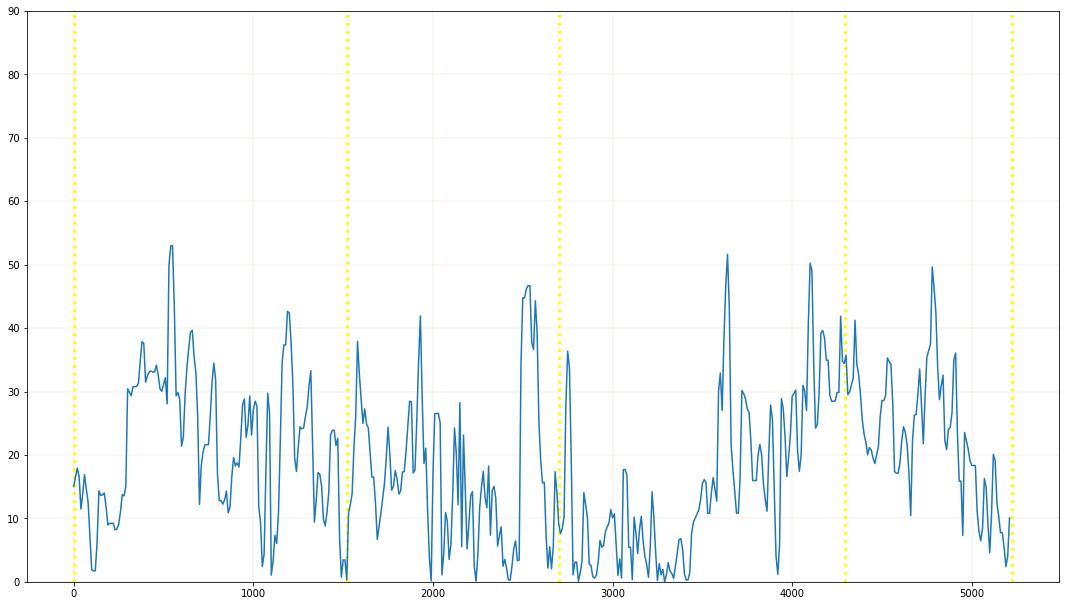

In [32]:
fig = plot(
    topographic_profile.as_abs_slopes_degrees(),
    breaklines_color='yellow',
    breaklines_width=3,
    z_min=0,
    z_max=90,
    grid=True
)


### Analizing a topographic profile

Analyses of a profile could be, among others:
- profile smoothing
- calculate splines
- detrend data
- calculate Auto Correlation Function (ACF)


https://learning.oreilly.com/library/view/practical-time-series/9781492041641/ch06.html#idm45554596280744

In [33]:
data = topographic_profile.y_arr()

from: https://anderfernandez.com/en/blog/how-to-program-with-python-and-r-in-the-same-jupyter-notebook/

In [34]:
%load_ext rpy2.ipython

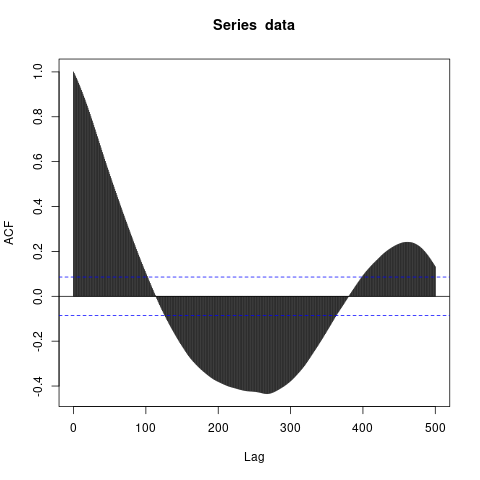

In [35]:
%%R -i data 
acf(data, lag.max=500)

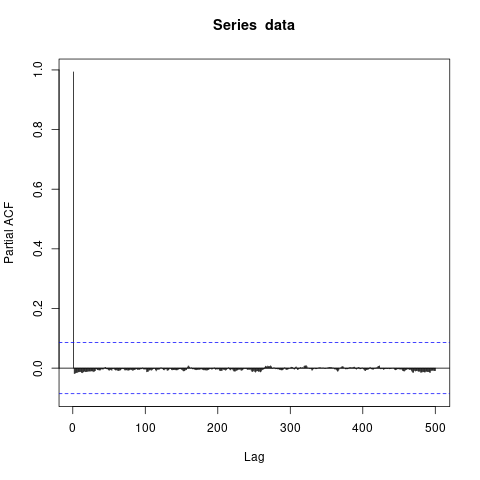

In [36]:
%%R -i data 
pacf(data, lag.max=500)

Moving average

from https://stackoverflow.com/questions/14313510/how-to-calculate-rolling-moving-average-using-numpy-scipy

In [37]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

In [38]:
smooth_50 = moving_average(data, 50)

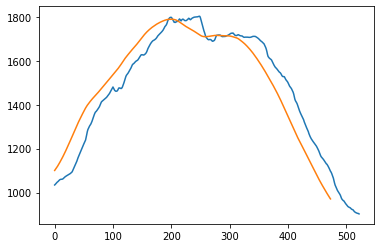

In [39]:
import matplotlib.pyplot as plt 
plt.plot(data)
plt.plot(smooth_50)

from https://stackoverflow.com/questions/14313510/how-to-calculate-rolling-moving-average-using-numpy-scipy

In [40]:
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

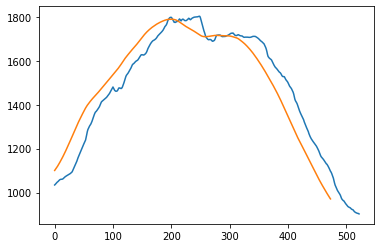

In [41]:
plt.plot(data)
plt.plot(moving_average(data, n=50))

from https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.wiener.html#scipy.signal.wiener

In [42]:
from scipy.signal.signaltools import wiener

In [43]:
filtered_data = wiener(data, (50,))  #Filter the image

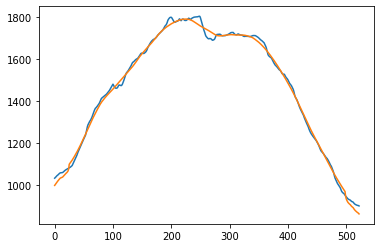

In [44]:
plt.plot(data)
plt.plot(filtered_data)

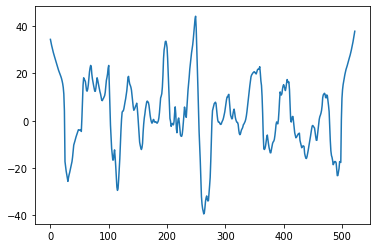

In [45]:
residuals = data - filtered_data
plt.plot(residuals)

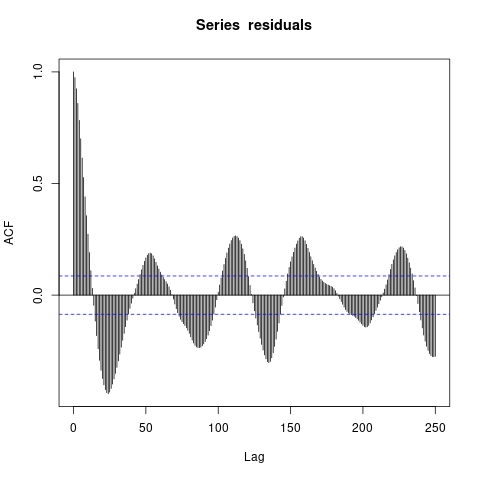

In [46]:
%%R -i residuals 
acf(residuals, lag.max=250)

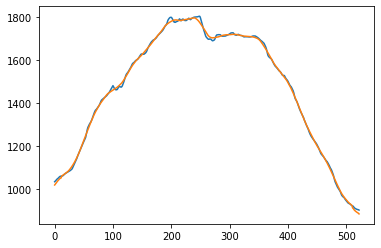

In [47]:
filtered_data = wiener(data, (25,))  #Filter the image
plt.plot(data)
plt.plot(filtered_data)

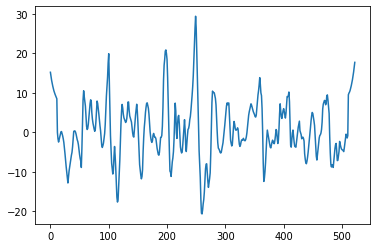

In [48]:
residuals = data - filtered_data
plt.plot(residuals)

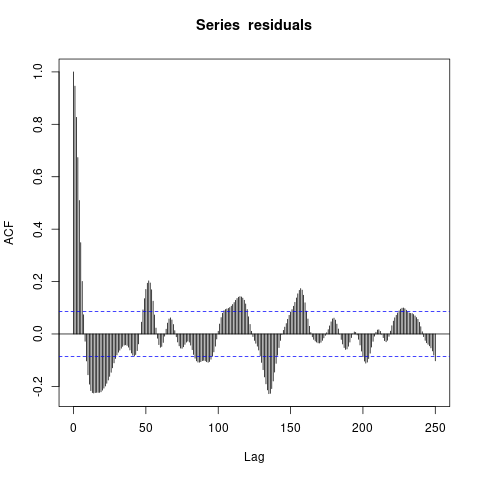

In [49]:
%%R -i residuals 
acf(residuals, lag.max=250)

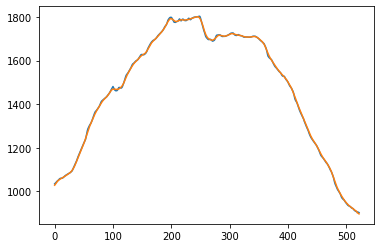

In [50]:
filtered_data = wiener(data, (10,))  #Filter the image
plt.plot(data)
plt.plot(filtered_data)

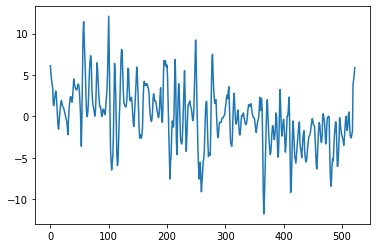

In [51]:
residuals = data - filtered_data
plt.plot(residuals)

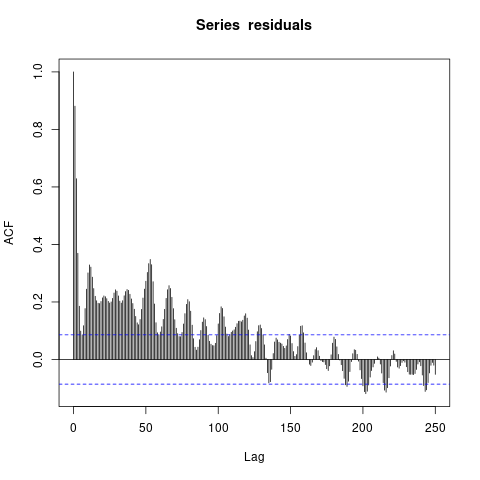

In [52]:
%%R -i residuals 
acf(residuals, lag.max=250)

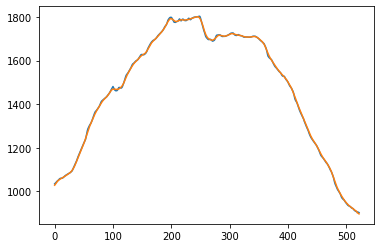

In [53]:
filtered_data = wiener(data, (10,))  #Filter the image
plt.plot(data)
plt.plot(filtered_data)

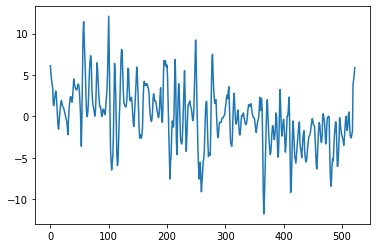

In [54]:
residuals = data - filtered_data
plt.plot(residuals)

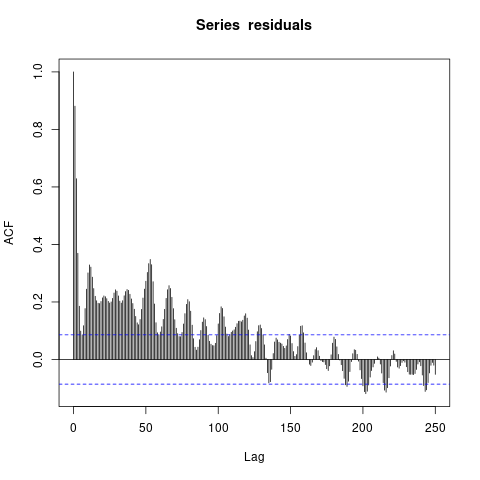

In [55]:
%%R -i residuals 
acf(residuals, lag.max=250)

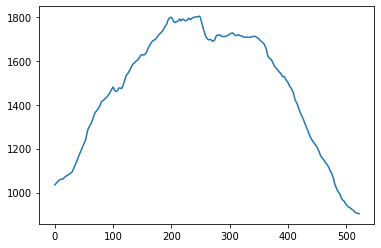

In [56]:
plt.plot(data)

from https://otexts.com/fpp2/non-seasonal-arima.html

In [58]:
%%R -i data 
library(forecast)
fit <- auto.arima(data, seasonal=FALSE)
fit

Series: data 
ARIMA(1,2,3) 

Coefficients:
         ar1      ma1      ma2      ma3
      0.6402  -0.3855  -0.3423  -0.1742
s.e.  0.0766   0.0829   0.0451   0.0579

sigma^2 estimated as 1.813:  log likelihood=-892.03
AIC=1794.06   AICc=1794.18   BIC=1815.34


In [61]:
%%R -i data 
library(forecast)
fit <- auto.arima(data, seasonal=TRUE)
fit

Series: data 
ARIMA(1,2,3) 

Coefficients:
         ar1      ma1      ma2      ma3
      0.6402  -0.3855  -0.3423  -0.1742
s.e.  0.0766   0.0829   0.0451   0.0579

sigma^2 estimated as 1.813:  log likelihood=-892.03
AIC=1794.06   AICc=1794.18   BIC=1815.34


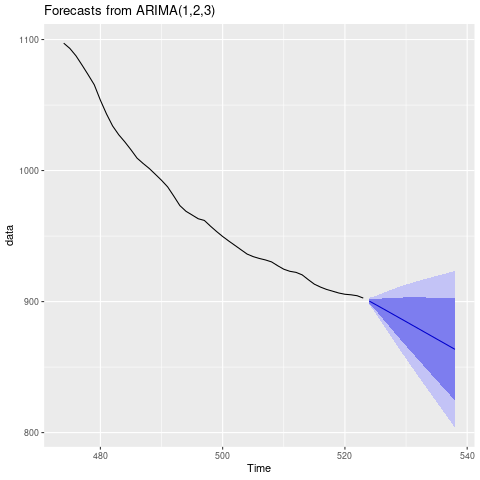

In [71]:
%%R
fit %>% forecast(h=15) %>% autoplot(include=50)

In [77]:
%%R
fit <- auto.arima(data, seasonal=FALSE)
fit2 <- Arima(data, order=c(2,0,1))
fit2

Series: data 
ARIMA(2,0,1) with non-zero mean 

Coefficients:
         ar1      ar2     ma1      mean
      1.9098  -0.9098  0.3724  1470.849
s.e.  0.0186   0.0186  0.0395       NaN

sigma^2 estimated as 1.909:  log likelihood=-910.71
AIC=1831.41   AICc=1831.53   BIC=1852.71


In [79]:
%%R
fit3 <- auto.arima(data, seasonal=FALSE,
  stepwise=FALSE, approximation=FALSE)
fit3

Series: data 
ARIMA(1,2,3) 

Coefficients:
         ar1      ma1      ma2      ma3
      0.6402  -0.3855  -0.3423  -0.1742
s.e.  0.0766   0.0829   0.0451   0.0579

sigma^2 estimated as 1.813:  log likelihood=-892.03
AIC=1794.06   AICc=1794.18   BIC=1815.34


In [80]:
%%R
fit4 <- auto.arima(data, seasonal=FALSE,
  stepwise=TRUE, approximation=FALSE)
fit4

Series: data 
ARIMA(3,2,1) 

Coefficients:
         ar1      ar2     ar3      ma1
      1.2131  -0.5222  0.1288  -0.9569
s.e.  0.0501   0.0657  0.0473   0.0235

sigma^2 estimated as 1.814:  log likelihood=-892.28
AIC=1794.56   AICc=1794.68   BIC=1815.84


Continue using:
- https://otexts.com/fpp2/non-seasonal-arima.html
- https://perma.cc/P9BK-764B
- https://learning.oreilly.com/library/view/practical-time-series/9781492041641/ch06.html#idm45554595882376


### Initializing a geoprofile

A *geoprofile* can be considered a container for all topographic and geological data associated with a single geological profile. The simplest way to construct it is by initializing an empty geoprofile, and adding profile elements afterwards.

In [ ]:
from pygsf.profiles.geoprofiles import GeoProfile

geoprofile = GeoProfile()

### Using a segment profiler

To create the topographic and geologic datasets needed for populating a geoprofile, we need an operative element, that allows to extract georeferenced information from the topographic grids and the various geological elements. In *pygsf* we may use a *segment profiler*, implemented in the *SegmentProfiler* class.
The data extracted with the profiler are then added to the *geoprofile*. 

We create a *SegmentProfiler* instance. It is defined by a segment, a sample spacing (in the example below, each 5 meters along the profile) and an EPSG code (32633).

In [ ]:
from pygsf.profiles.profilers import SegmentProfiler

segment = Segment2D(start_pt=line.start_pt(), end_pt=line.end_pt())
segment_profiler = SegmentProfiler(
    segment2d=segment, 
    densify_distance= 5, # meters sampling distance along profile
    epsg_cd = 32633
)

In [ ]:
segment_profiler

Using a sampling distance of 5 meters along the profile, we create a straight profile composed by slightly more than 1,000 points. 

In [ ]:
segment_profiler.num_pts()

### Adding a topographic profile

With at least one grid (the geoarray) and a segment profiler we can create a topographic profile.

In [ ]:
topographic_profile = segment_profiler.profile_grid(geoarray)

In [ ]:
print("Type of 'topographic_profile': {}".format(type(topographic_profile)))

In [ ]:
print(topographic_profile)

The variable *topographic_profile* is an instance of the *XYArrayPair* class. 
Since we used just one grid as the input parameter for the *profile_grids* method, there is just a single topographic profile stored into the result list.

In [ ]:
from pygsf.plots.profiles import plot
plot(topographic_profile)

Now we can add the topographic profile to the geological profile:

In [ ]:
geoprofile.topo_profile = topographic_profile

and plot it:

In [ ]:
from pygsf.plots.profiles import plot

fig = plot(geoprofile)

We may note the text "Profile attitudes: None" above the plot. It means that no geological attitude is associated with the profile. We add them in the following steps.

### Plotting geological attitudes

A few geological attitudes in the proximity of the profiles are available in a point shapefile:

In [ ]:
attitudes_shape = "/home/mauro/Documents/projects/gsf/example_data/mt_alpi/attitudes.shp"

By using the *geopandas* module we can read the data. They are stored in a *geopandas.GeoDataFrame* instance.

In [ ]:
import geopandas

attitudes = geopandas.read_file(attitudes_shape)

attitudes

The data projection can be read with the *crs* geodataframe class attribute:

In [ ]:
attitudes.crs

The projection of the source dataset is UTM33, as are the DEM and the profile, so we do not need any reprojection.

To see the read data, we use the geopandas *plot* method:

In [ ]:
ax = attitudes.plot()

While the geopandas tools are handy for reading vectorial data, we need to read the source attitude data as a list of pygsf *GeorefAttitude* instances, in order to process them for the profile creation.

We use the quite verbose '*try_extract_flat_georeferenced_attitudes*' function from pygsf. 

In [ ]:
from pygsf.utils.profiles.geopandas import try_extract_flat_georeferenced_attitudes

success, result = try_extract_flat_georeferenced_attitudes(
    geodataframe = attitudes, 
    azim_fldnm = "dip_dir", 
    dip_ang_fldnm = "dip_ang"
)

Checking if we had success or not:

In [ ]:
print(success)

if not success:
    
    msg = result
    print(msg)
    
else:
    
    attitudes = result

Ok, if *true* we can go on and look at the data characteristics:

In [ ]:
print("Number of attitudes: {}".format(len(attitudes)))

There are eleven attitudes available. To look at their details, we just use *pprint*:

In [ ]:
pprint(attitudes)

A georeferenced attitude is defined by its *id* (a progressive counter, having not provided a field name to the '*try_extract_flat_georeferenced_attitudes function*'), *position* and *attitude*. 

We note that the attitude points are 2D. To plot them in a topographic profile, they need to present also the elevation information. To calculate it, we use the grid previously read within the *pygsf* *georef_attitudes_3d_from_grid* function.

In [ ]:
from pygsf.profiles.profilers import georef_attitudes_3d_from_grid

attitudes_3d = georef_attitudes_3d_from_grid(
        structural_data=attitudes,
        height_source=geoarray,
)

Let's have a look at the computed data:

In [ ]:
for att3d in attitudes_3d:
    print(att3d)

Now the attitudes have a 3D point. We can therefore proceed calculating the projections of the attitude on the section. 

In this example, we choose the 'nearest' mapping method for projecting the attitudes on the section: it projects the attitude normally to the profile.

In [ ]:
mapping_method = {}
mapping_method['method'] = 'nearest'

projected_attitudes = segment_profiler.map_georef_attitudes_to_section(
            attitudes_3d = attitudes_3d,
            mapping_method = mapping_method)

In [ ]:
for att in projected_attitudes:
    print("\n" + str(att))

Resulting profile attitudes are automatically sorted by their increasing distance along the profile (field 's'). The main fields are:
- *id*: identifier inherited from the georeferenced attitudes
- *s*: the distance of the projected attitude along the profile (may be negative or exceeed the profile length)
- *z*: the projected attitude elevation in the profile
- *slope_degr*: the resulting slope, in degrees 
- *down_sense*: describes whether the plane plunges to the right or to the left
- *dist*: the distance between the original attitude location and its projection (according to the chosen method) on the profile plane.

We assign the projected attitudes to the profile:

In [ ]:
geoprofile.profile_attitudes = projected_attitudes

The plot is possible with the usual *plot* method:

In [ ]:
fig = plot(geoprofile)

## 2 - Timpa San Lorenzo area (Calabria, Southern Italy) (in preparation)

Now we move around 35 km to the South-East of the Mt. Alpi are, and consider the Timpa San Lorenzo area, in Calabria, East of Mt. Pollino range.

The height source data is the TinItaly DEM.

In [ ]:
src_dem = "/home/mauro/Documents/projects/gsf/example_data/timpa_san_lorenzo/tsl_tinitaly_w84u32.tif"
src_profile = "/home/mauro/Documents/projects/gsf/example_data/timpa_san_lorenzo/profile.shp"

In [ ]:
from pygsf.io.rasters.gdal import try_read_raster_band
success, result = try_read_raster_band(raster_source=src_dem)

In [ ]:
print(success, result)

In [ ]:
geotransform, projection, band_params, data = result

In [ ]:
geoarray = GeoArray(
    geotransform=geotransform,
    epsg_code=32633,
    arrays=[data]    
)

In [ ]:
fig = plot_grid(geoarray)

In [ ]:
success, result = try_read_line_shp_with_attr(src_profile)

print(success)

In [ ]:
print(result)

In [ ]:
geolines = result[0][0]

In [ ]:
print(geolines)

In [ ]:
geoline = geolines[0]

In [ ]:
print(geoline.shape)

In [ ]:
line = geoline.shape

In [ ]:
plot_line(fig, line)

In [ ]:
from pygsf.profiles.geoprofiles import GeoProfileSet

geoprofiles = GeoProfileSet()

segment = Segment2D(start_pt=line.start_pt(), end_pt=line.end_pt())
base_profiler = SegmentProfiler(
    segment2d = segment, 
    densify_distance= 5,
    epsg_cd=32633
)

In [ ]:
base_profiler

In [ ]:
base_profiler.num_pts()

In [ ]:
from pygsf.profiles.profilers import ParallelProfilers

multiple_profilers = ParallelProfilers(
             base_profiler=base_profiler,
             num_profiles=15,
             offset=500,
             profs_arr="central"
)

In [ ]:
multiple_profilers

In [ ]:
topo_profiles = multiple_profilers.profile_grid(geoarray)

In [ ]:
print(type(topo_profiles))

They constitute a TopographicProfileSet instance.

In [ ]:
geoprofiles.topo_profiles_set = topo_profiles    

In [ ]:
fig = plot(geoprofiles)

### Line intersections

In [ ]:
import geopandas
faults_shape = "/home/mauro/Documents/projects/gsf/example_data/timpa_san_lorenzo/faults.shp"
faults = geopandas.read_file(faults_shape)
faults

In [ ]:
type(faults)

In [ ]:
type(faults['geometry'][0])

In [ ]:
from pygsf.io.vectors.gdal import reading_line_shapefile

In [ ]:
success, answer = reading_line_shapefile(
    shp_path=faults_shape,
    flds=['fid', 'name'])

In [ ]:
print(success)

In [ ]:
results = answer

In [ ]:
pprint(results)

Here we check the type of the imported elements.

In [ ]:
line_types = set(map(lambda val: type(val[0]), results))
print(line_types)

They are all Line instances.

We filter the lines to be 'Timpa San Lorenzo thrust flat' elements.

In [ ]:
from operator import itemgetter
tsl_faults = [rec[0] for rec in results if rec[1][1] == 'Timpa San Lorenzo thrust flat']

In [ ]:
pprint(tsl_faults)

This is the set of line elements of the 'Timpa San Lorenzo thrust flat'.

## Test of intersection with single line profile

In [ ]:
base_profiler

In [ ]:
topo_profile = base_profiler.profile_grid(geoarray)

We construct a geological profile object, empty for now.

In [ ]:
geoprofile = GeoProfile()

Add the topographic profile to the geological profile and plot the former.

In [ ]:
geoprofile.topo_profile = topo_profile
fig = plot(geoprofile)

Now we try plotting the Timpa San Lorenzo flat intersection with the current profile.

In [ ]:
pprint(tsl_faults)

In [ ]:
line_intersections = base_profiler.intersect_lines(tsl_faults)

In [ ]:
pprint(line_intersections)

In [ ]:
profile_intersections = base_profiler.parse_profile_intersections(line_intersections)

In [ ]:
pprint(profile_intersections)

In [ ]:
geoprofile.lines_intersections = profile_intersections

In [ ]:
fig = plot(geoprofile)

## Analysing data with R

Help from:
 - https://thomas-cokelaer.info/blog/2012/04/how-to-call-r-plotting-function-from-python-using-rpy2/
 

To close non-inline graphics:

In [ ]:
try:
    r['dev.off']()
except:
    print("Already closed")

The data arrays are extracted from the topographic profile.

In [ ]:
s, z = topo_profile.x_arr(), topo_profile.y_arr()

Help from:
 - https://blog.jupyter.org/i-python-you-r-we-julia-baf064ca1fb6
 
 I Python, You R, We Julia
Matthias Bussonnier
Matthias Bussonnier
May 29, 2018 · 8 min read

In [ ]:
%load_ext rpy2.ipython

In [ ]:
%Rpush s z

In [ ]:
%%R
plot(s, z, type="l", col="blue", ylim=c(500, 2000))
hist(z, col="orange")